In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*1.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


lonmin:  0
lonmax:  360


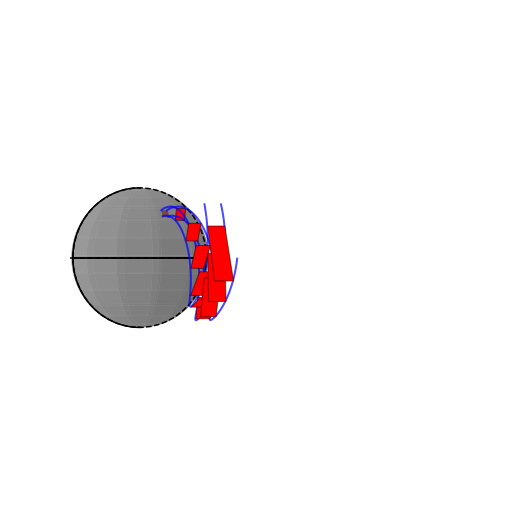

In [4]:
from matplotlib import collections  as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors


# ax = a3.Axes3D(pl.figure())
# for i in range(10000):
#     vtx = sp.rand(3,3)
#     tri = a3.art3d.Poly3DCollection([vtx])
#     tri.set_color(colors.rgb2hex(sp.rand(3)))
#     tri.set_edgecolor('k')
#     ax.add_collection3d(tri)


# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/lightning_power_study/rays/geometric_spreading_example/'
rayF = 200
lat_min = 0
lat_max = 90
lon_min = 0
lon_max = 360

flashtime = dt.datetime(2010, 8, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
H_IONO = 1000e3
D2R = (np.pi/180.0)

rf = read_rayfiles(ray_root,rayF,lat_min, lat_max, lon_min, lon_max)

t_new = np.arange(0,5, step=0.05)

plane_inds = np.arange(0, len(t_new), step=10)

psize = 2
# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    interp_ray(tmp_coords, t_new)
    
    rays.append(tmp_coords)

#     derp = tmp_coords[0]
#     derp = derp.convert('MAG','sph')
#     print derp
    

# -------- 3D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")
ax._axis3don = False


# # Plot the earth
plot_earth(ax)


# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=2, color='blue', alpha=0.7)


    
# Plot polygons:
for ind in plane_inds:
    vtx = np.array([ [b.x[ind], b.y[ind], b.z[ind]] for b in [rays[0], rays[1], rays[3], rays[2]]])/R_E
    tri = a3.art3d.Poly3DCollection([vtx], color='#ff0000', alpha=0.5)
    tri.set_edgecolor('k')
    ax.add_collection3d(tri)


ax.set_xlim([-psize, psize])
ax.set_ylim([0, 2*psize])
ax.set_zlim([-psize, psize])

ax.view_init(elev=0., azim=-20)
# for ii in xrange(0,360,1):
#     ax.view_init(elev=10., azim=ii)
#     plt.draw()
#     plt.show()
#     time.sleep(1)

In [3]:
def plot_earth(ax):
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
    elev = 0.0
    rot = 0 / 180 * np.pi
    ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='grey', linewidth=0, alpha=0.5)
    a = np.array([-np.sin(elev / 180 * np.pi), 0, np.cos(elev / 180 * np.pi)])
    b = np.array([0, 1, 0])
    b = b * np.cos(rot) + np.cross(a, b) * np.sin(rot) + a * np.dot(a, b) * (1 - np.cos(rot))
    ax.plot(np.sin(u),np.cos(u),0,color='k', linestyle = 'dashed')
    horiz_front = np.linspace(0, np.pi, 100)
    ax.plot(np.sin(horiz_front),np.cos(horiz_front),0,color='k')
    vert_front = np.linspace(np.pi / 2, 3 * np.pi / 2, 100)
    ax.plot(a[0] * np.sin(u) + b[0] * np.cos(u), b[1] * np.cos(u), a[2] * np.sin(u) + b[2] * np.cos(u),color='k', linestyle = 'dashed')
    ax.plot(a[0] * np.sin(vert_front) + b[0] * np.cos(vert_front), b[1] * np.cos(vert_front), a[2] * np.sin(vert_front) + b[2] * np.cos(vert_front),color='k')

    # Meshgrid version (faster, uglier)
    # u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    # x=np.cos(u)*np.sin(v)
    # y=np.sin(u)*np.sin(v)
    # z=np.cos(v)
    # ax.plot_wireframe(x, y, z, color="grey")
    # Plot the earth


In [2]:

def interp_ray(rc, taxis):
    '''in-place interpolation of position (xyz) and sim time axes'''
    ix = interpolate.interp1d(rc.sim_time, rc.x)
    iy = interpolate.interp1d(rc.sim_time, rc.y)
    iz = interpolate.interp1d(rc.sim_time, rc.z)

    rc.x = ix(taxis)
    rc.y = iy(taxis)
    rc.z = iz(taxis)
    rc.sim_time = taxis
    

rc = rays[0]
taxis = np.arange(0, 10, step=0.1)
print np.shape(rc.sim_time)
print np.shape(rc.x)
ix = interpolate.interp1d(rc.sim_time, rc.x)
newx = ix(taxis)

plt.figure()
plt.plot(rc.sim_time, rc.x, 'r--')

interp_ray(rc, taxis)
plt.plot(rc.sim_time, rc.x, 'b-')

NameError: name 'rays' is not defined

<IPython.core.display.Javascript object>


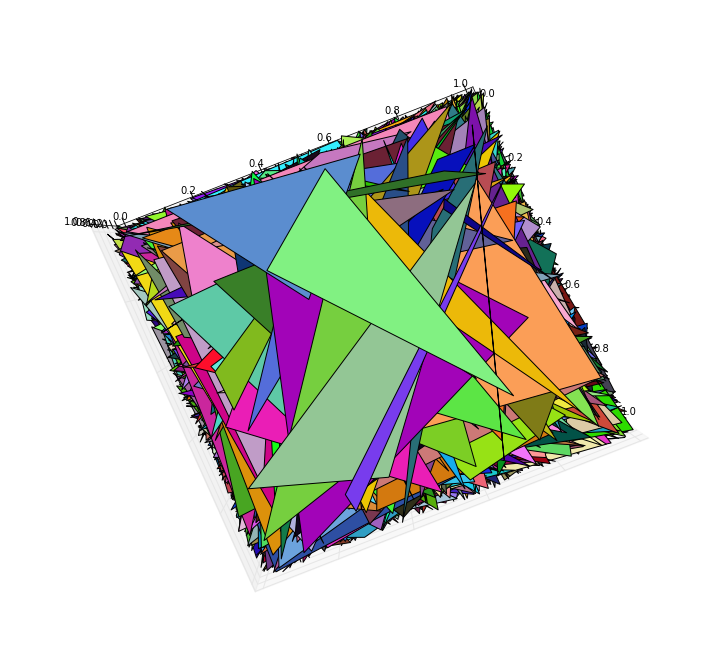

In [6]:
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import pylab as pl
import scipy as sp

ax = a3.Axes3D(pl.figure())
for i in range(10000):
    vtx = sp.rand(3,3)
    tri = a3.art3d.Poly3DCollection([vtx])
    tri.set_color(colors.rgb2hex(sp.rand(3)))
    tri.set_edgecolor('k')
    ax.add_collection3d(tri)
pl.show()